In [36]:
!pip install tensorflow_probability

In [43]:
import os
import sys
import matplotlib.pyplot as plt

if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
sys.path.append('training-instrumentation-toolkit')
import train_instrumentation as tinstr
import train_explainer as texpl

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from preprocessing import trainTestClean
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [44]:
df_train, df_test = trainTestClean()

X_train = df_train.drop(columns=['price', 'id'])
y_train = df_train['price'].values.reshape(-1, 1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))

X_test = df_test.drop(columns=['price', 'id'])
y_test = df_test['price'].values.reshape(-1, 1)

X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled))
 

In [45]:
variables = tinstr.VariableHistoryCallback(per_step=True)
gradients = tinstr.GradientHistoryCallback(per_step=True)
outputs = tinstr.LayerOutputHistoryCallback(per_step=True)
output_gradients = tinstr.LayerOutputGradientHistoryCallback(per_step=True)

In [ ]:
# not as interesting as I though (leakyReLu)
'''model = Sequential([
    
    keras.Input((93,)),

    layers.Dense(512),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(), 
    layers.Dropout(0.2),

    layers.Dense(256),
    layers.LeakyReLU(negative_slope=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)
    ])'''

In [ ]:
model = Sequential([
    keras.Input((93,)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.2),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1)
    ])

In [47]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

In [48]:
batched_train = dataset.batch(32)
batched_test = test_dataset.batch(32)

history = tinstr.fit(model, batched_train, epochs=10, validation_data=batched_test, callbacks=[
    variables, gradients, outputs, output_gradients, tinstr.HistoryStats(per_step=True)])

Epoch 1/10


1269/1269 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - loss: 0.9054 - mae: 0.6788 - mse: 0.9054 - val_loss: 0.7309 - val_mae: 0.3201 - val_mse: 0.7309
Epoch 2/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - loss: 0.2468 - mae: 0.3503 - mse: 0.2468 - val_loss: 1.8016 - val_mae: 0.2642 - val_mse: 1.8016
Epoch 3/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - loss: 0.1886 - mae: 0.3036 - mse: 0.1886 - val_loss: 1.7449 - val_mae: 0.2250 - val_mse: 1.7449
Epoch 4/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - loss: 0.1483 - mae: 0.2688 - mse: 0.1483 - val_loss: 1.6331 - val_mae: 0.2025 - val_mse: 1.6331
Epoch 5/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - loss: 0.1168 - mae: 0.2420 - mse: 0.1168 - val_loss: 1.4249 - val_mae: 0.1863 - val_mse: 1.4249
Epoch 6/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - loss: 0.1044 - mae: 0.2315 - mse: 0.1044 - val_loss: 1.2891 - val_mae: 0.1888 - val_mse: 1.2891
Epoch 7/10
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - loss: 0.0950 - mae: 0.2213 - 

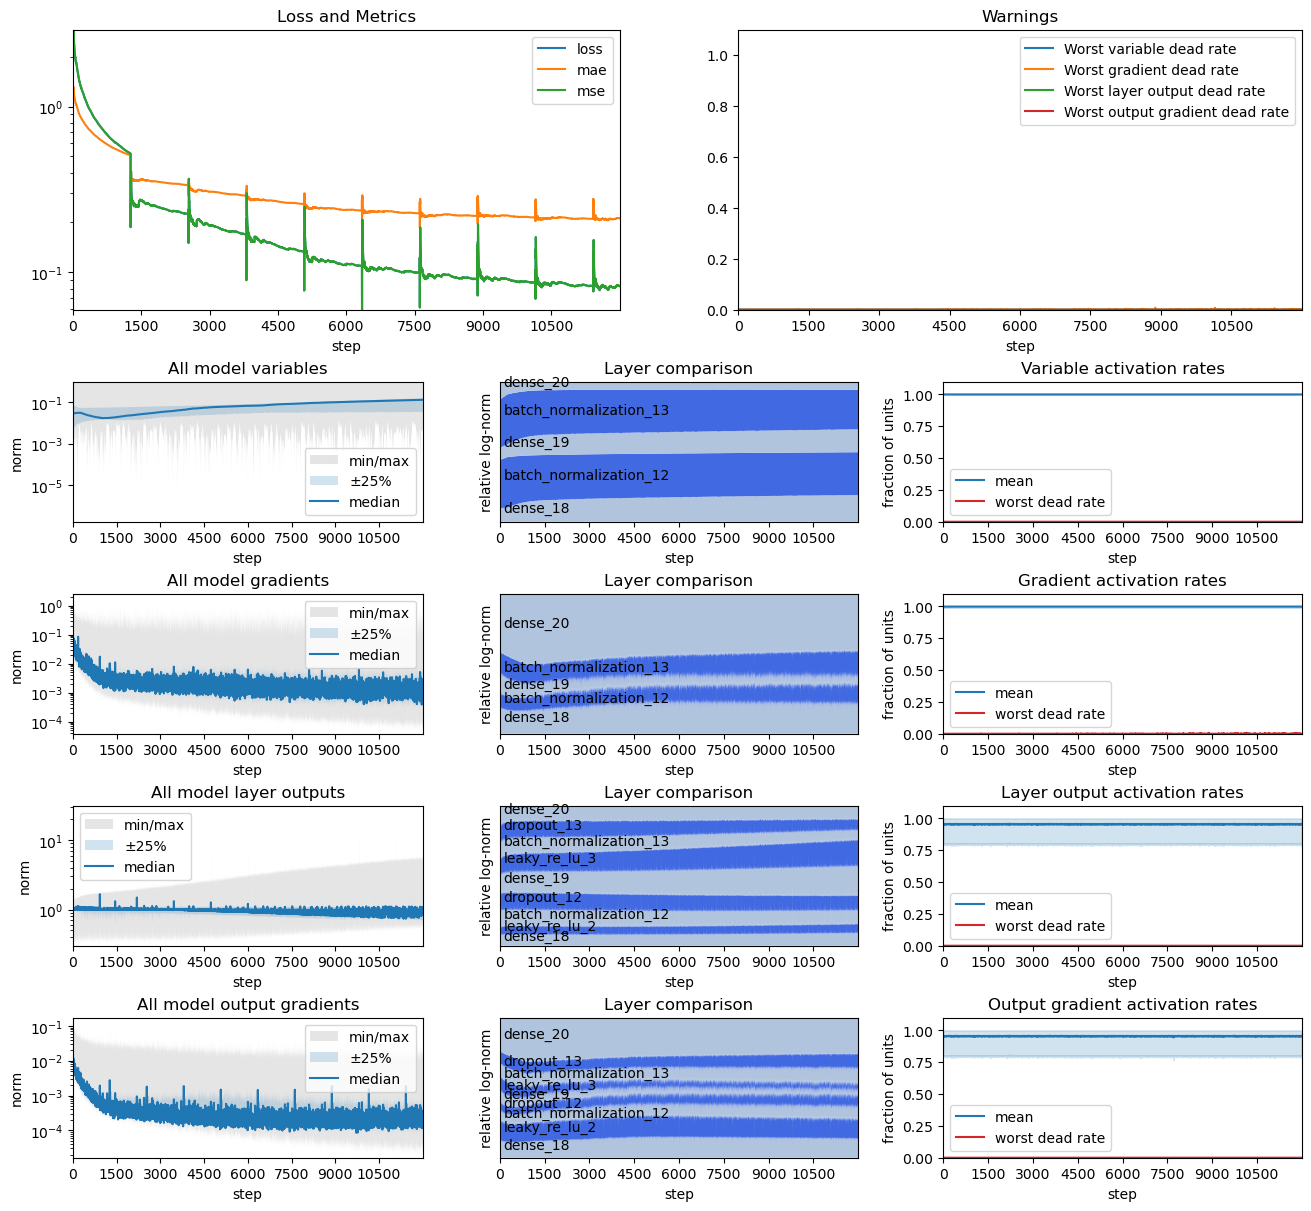

In [49]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients], iterations=slice(0, 12000))

In [50]:
preds = model.predict(X_test_scaled)
preds_real = y_scaler.inverse_transform(preds)

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


In [51]:
preds_real

array([[239562.94],
       [612185.75],
       [380157.53],
       ...,
       [448258.03],
       [497546.72],
       [687840.94]], dtype=float32)

In [52]:
# MAE
mae = mean_absolute_error(y_test, preds_real)

# MAPE
mape = mean_absolute_percentage_error(y_test, preds_real)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")

MAE: 30934.94
MAPE: 10.23%


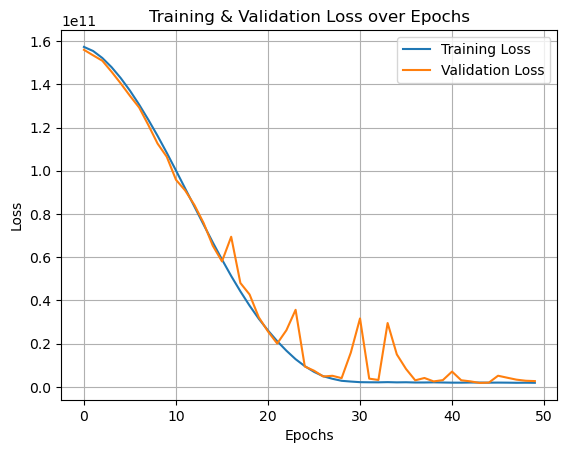

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

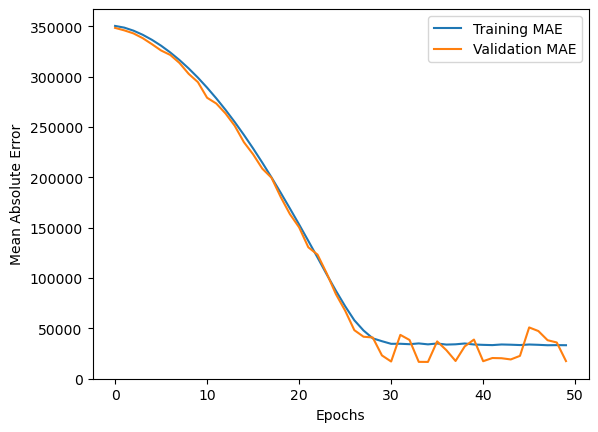

In [ ]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:
X_test_scaled = scaler.transform(X_test.drop(columns=['id']))
test_loss = model.evaluate(X_test_scaled, y_test)